## Importing Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import os
import re
from scipy.fft import fft, fftfreq
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import random

## Configuration

In [3]:
def set_seed(seed=42):
    """Set all random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

# Call this at the very beginning
set_seed(42)

# Configuration
BASE_DIR = r"D:\Research\Multiphase Visual Twin\Papers\Paper1\Project\20Hz-Training-Dataset"
SUB_FOLDERS = ["Dispersed-Flow", "Plug-Flow", "Slug-Flow"]
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Physics constants
PIPE_DIAMETER = 2 * 0.0254
PIPE_LENGTH = 7.25
GRAVITY = 9.81
RHO_WATER = 998
RHO_AIR_MEAN = 1.49

# Hyperparameters
WINDOW_SIZE = 40
STRIDE = 20
BATCH_SIZE = 16
EPOCHS = 200
LEARNING_RATE = 0.0005
LAMBDA_CLASS = 0.7
LAMBDA_PHYSICS = 0.3
LAMBDA_DATA = 0.2
LAMBDA_VELOCITY = 0.7  # New: weight for velocity regression loss 0.7 -> 0.6
K_FOLDS = 5
WEIGHT_DECAY = 1e-4

## PhysicsNet (Feature Extraction)

In [4]:
def extract_velocities_from_filename(filename):
    vsg_match = re.search(r'Vsg=([\d.]+)', filename)
    vsl_match = re.search(r'Vsl=([\d.]+)', filename)
    vsg = float(vsg_match.group(1)) if vsg_match else 0.0
    vsl = float(vsl_match.group(1)) if vsl_match else 0.0
    return vsg, vsl

def extract_features(pressure_window):
    features = []
    features.append(np.mean(pressure_window))
    features.append(np.std(pressure_window))
    features.append(np.max(pressure_window) - np.min(pressure_window))
    gradient = np.gradient(pressure_window)
    features.append(np.mean(gradient))
    features.append(np.std(gradient))
    features.append(np.max(np.abs(gradient)))
    if len(pressure_window) > 4:
        freqs = fftfreq(len(pressure_window), d=0.5)
        fft_vals = np.abs(fft(pressure_window))
        positive_freqs = freqs[:len(freqs)//2]
        positive_fft = fft_vals[:len(fft_vals)//2]
        if len(positive_fft) > 0:
            dominant_freq_idx = np.argmax(positive_fft)
            features.append(positive_freqs[dominant_freq_idx])
            features.append(positive_fft[dominant_freq_idx])
        else:
            features.append(0.0)
            features.append(0.0)
    else:
        features.append(0.0)
        features.append(0.0)
    return np.array(features)


## Data Loading

In [5]:
def load_data():
    all_data = []
    for idx, folder in enumerate(SUB_FOLDERS):
        folder_path = os.path.join(BASE_DIR, folder)
        files = sorted([f for f in os.listdir(folder_path) if f.endswith('.xlsx')])  # Sort for consistency
        for file in files:
            file_path = os.path.join(folder_path, file)
            df = pd.read_excel(file_path)
            if 'Pressure (barA)' in df.columns:
                pressure = df['Pressure (barA)'].values
                vsg, vsl = extract_velocities_from_filename(file)
                for i in range(0, len(pressure) - WINDOW_SIZE + 1, STRIDE):
                    window = pressure[i:i+WINDOW_SIZE]
                    if len(window) == WINDOW_SIZE:
                        features = extract_features(window)
                        all_data.append({
                            'pressure_window': window,
                            'features': features,
                            'vsg': vsg,
                            'vsl': vsl,
                            'label': idx
                        })
    return all_data

class FlowRegimeDataset(Dataset):
    def __init__(self, data, scaler_features=None, scaler_pressure=None, 
                 scaler_vsg=None, scaler_vsl=None):
        self.data = data
        pressure_windows = np.array([d['pressure_window'] for d in data])
        features = np.array([d['features'] for d in data])
        vsg = np.array([d['vsg'] for d in data]).reshape(-1, 1)
        vsl = np.array([d['vsl'] for d in data]).reshape(-1, 1)
        
        # Scale pressure windows
        if scaler_pressure is None:
            self.scaler_pressure = StandardScaler()
            pressure_windows = self.scaler_pressure.fit_transform(pressure_windows)
        else:
            self.scaler_pressure = scaler_pressure
            pressure_windows = self.scaler_pressure.transform(pressure_windows)
        
        # Scale features
        if scaler_features is None:
            self.scaler_features = StandardScaler()
            features = self.scaler_features.fit_transform(features)
        else:
            self.scaler_features = scaler_features
            features = self.scaler_features.transform(features)
        
        # FIX: Scale velocities SEPARATELY using RobustScaler (better for outliers)
        # This fixes the clustering issue in Vsg predictions
        if scaler_vsg is None:
            self.scaler_vsg = RobustScaler()
            vsg_scaled = self.scaler_vsg.fit_transform(vsg)
        else:
            self.scaler_vsg = scaler_vsg
            vsg_scaled = self.scaler_vsg.transform(vsg)
        
        if scaler_vsl is None:
            self.scaler_vsl = RobustScaler()
            vsl_scaled = self.scaler_vsl.fit_transform(vsl)
        else:
            self.scaler_vsl = scaler_vsl
            vsl_scaled = self.scaler_vsl.transform(vsl)
        
        # Combine scaled velocities for input
        velocities_scaled = np.hstack([vsg_scaled, vsl_scaled])
        
        self.pressure_windows = torch.FloatTensor(pressure_windows)
        self.features = torch.FloatTensor(features)
        self.velocities_input = torch.FloatTensor(velocities_scaled)
        self.labels = torch.LongTensor([d['label'] for d in data])
        
        # FIX: Use SCALED velocities as targets (consistent with input)
        self.vsg_target = torch.FloatTensor(vsg_scaled)
        self.vsl_target = torch.FloatTensor(vsl_scaled)
        
        # Store raw velocities for later inverse transformation
        self.vsg_raw = vsg
        self.vsl_raw = vsl
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return {
            'pressure_window': self.pressure_windows[idx],
            'features': self.features[idx],
            'velocities': self.velocities_input[idx],
            'label': self.labels[idx],
            'vsg': self.vsg_target[idx],
            'vsl': self.vsl_target[idx]
        }


## Multi-Task PINN Model

In [6]:
class MultiTaskPINN(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_classes=3):
        super(MultiTaskPINN, self).__init__()
        
        # Shared CNN backbone for pressure signal processing
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.4)
        
        # Feature processing
        self.fc_features = nn.Sequential(
            nn.Linear(8, 64),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        
        # Velocity processing (for input velocities)
        self.fc_velocities = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        
        conv_output_size = 64 * (WINDOW_SIZE // 2)
        combined_size = conv_output_size + 64 + 32
        
        # Shared representation layer
        self.shared_layer = nn.Sequential(
            nn.Linear(combined_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        
        # Task 1: Flow Regime Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size // 2, num_classes)
        )
        
        # Task 2: Velocity Regression Head (Vsg and Vsl)
        self.velocity_regressor = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size // 2, 32),
            nn.ReLU(),
            nn.Linear(32, 2)  # Output: [Vsg, Vsl]
        )
        
        # Task 3: Physics-based pressure prediction
        self.physics_net = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
    
    def forward(self, pressure_window, features, velocities):
        # Process pressure signal through CNN
        x = pressure_window.unsqueeze(1)
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        
        # Process features and velocities
        feat = self.fc_features(features)
        vel = self.fc_velocities(velocities)
        
        # Combine all features
        combined = torch.cat([x, feat, vel], dim=1)
        
        # Shared representation
        shared_repr = self.shared_layer(combined)
        
        # Multi-task outputs
        class_output = self.classifier(shared_repr)
        velocity_output = self.velocity_regressor(shared_repr)
        physics_output = self.physics_net(shared_repr)
        
        return class_output, velocity_output, physics_output

### Loss Function

In [7]:
def physics_loss(pressure_window, vsg, vsl, physics_pred):
    """Physics-informed loss based on pressure gradient"""
    pressure_grad = torch.gradient(pressure_window, dim=1)[0]
    mean_pressure_grad = pressure_grad.mean(dim=1, keepdim=True)
    
    vm = vsg + vsl
    void_fraction = vsg / (vm + 1e-8)
    rho_tp = void_fraction * RHO_AIR_MEAN + (1 - void_fraction) * RHO_WATER
    dp_dz_grav = rho_tp * GRAVITY / 100000
    
    residual = torch.abs(physics_pred - dp_dz_grav)
    return residual.mean()

## Training Function

In [8]:
def train_fold_multitask(model, train_loader, val_loader, criterion_class, 
                         criterion_velocity, optimizer, scheduler, fold):
    """Training function for multi-task learning"""
    train_losses = []
    train_class_losses = []
    train_velocity_losses = []
    train_physics_losses = []
    train_accs = []
    
    val_losses = []
    val_class_losses = []
    val_velocity_losses = []
    val_accs = []
    val_velocity_maes = []
    
    best_val_acc = 0.0
    best_val_velocity_mae = float('inf')
    # patience = 15
    patience_counter = 0
    
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0
        train_loss_class = 0.0
        train_loss_velocity = 0.0
        train_loss_physics = 0.0
        train_correct = 0
        train_total = 0
        
        for batch in train_loader:
            if batch['label'].size(0) <= 1:
                continue
            
            pressure = batch['pressure_window'].to(DEVICE)
            features = batch['features'].to(DEVICE)
            velocities = batch['velocities'].to(DEVICE)
            labels = batch['label'].to(DEVICE)
            vsg_target = batch['vsg'].to(DEVICE)
            vsl_target = batch['vsl'].to(DEVICE)
            
            # Properly stack velocity targets (scaled)
            velocity_target = torch.cat([vsg_target, vsl_target], dim=1)
            
            optimizer.zero_grad()
            
            # Forward pass
            class_output, velocity_output, physics_output = model(pressure, features, velocities)
            
            # Multi-task losses
            loss_class = criterion_class(class_output, labels)
            loss_velocity = criterion_velocity(velocity_output, velocity_target)
            loss_physics = physics_loss(pressure, vsg_target, vsl_target, physics_output)
            mean_pressure = pressure.mean(dim=1, keepdim=True)
            loss_data = nn.MSELoss()(physics_output, mean_pressure)
            
            # Combined loss
            loss = (LAMBDA_CLASS * loss_class + 
                   LAMBDA_VELOCITY * loss_velocity + 
                   LAMBDA_PHYSICS * loss_physics + 
                   LAMBDA_DATA * loss_data)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            train_loss_class += loss_class.item()
            train_loss_velocity += loss_velocity.item()
            train_loss_physics += loss_physics.item()
            
            _, predicted = torch.max(class_output, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        train_acc = 100 * train_correct / train_total if train_total > 0 else 0
        avg_train_loss = train_loss / len(train_loader)
        avg_train_loss_class = train_loss_class / len(train_loader)
        avg_train_loss_velocity = train_loss_velocity / len(train_loader)
        avg_train_loss_physics = train_loss_physics / len(train_loader)
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_loss_class = 0.0
        val_loss_velocity = 0.0
        val_correct = 0
        val_total = 0
        val_velocity_mae = 0.0
        val_velocity_count = 0
        
        with torch.no_grad():
            for batch in val_loader:
                pressure = batch['pressure_window'].to(DEVICE)
                features = batch['features'].to(DEVICE)
                velocities = batch['velocities'].to(DEVICE)
                labels = batch['label'].to(DEVICE)
                vsg_target = batch['vsg'].to(DEVICE)
                vsl_target = batch['vsl'].to(DEVICE)
                
                velocity_target = torch.cat([vsg_target, vsl_target], dim=1)
                
                class_output, velocity_output, physics_output = model(pressure, features, velocities)
                
                loss_class = criterion_class(class_output, labels)
                loss_velocity = criterion_velocity(velocity_output, velocity_target)
                loss_physics = physics_loss(pressure, vsg_target, vsl_target, physics_output)
                mean_pressure = pressure.mean(dim=1, keepdim=True)
                loss_data = nn.MSELoss()(physics_output, mean_pressure)
                
                loss = (LAMBDA_CLASS * loss_class + 
                       LAMBDA_VELOCITY * loss_velocity + 
                       LAMBDA_PHYSICS * loss_physics + 
                       LAMBDA_DATA * loss_data)
                
                val_loss += loss.item()
                val_loss_class += loss_class.item()
                val_loss_velocity += loss_velocity.item()
                
                _, predicted = torch.max(class_output, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                # Calculate MAE for velocities
                velocity_mae = torch.mean(torch.abs(velocity_output - velocity_target))
                val_velocity_mae += velocity_mae.item() * labels.size(0)
                val_velocity_count += labels.size(0)
        
        val_acc = 100 * val_correct / val_total if val_total > 0 else 0
        avg_val_loss = val_loss / len(val_loader)
        avg_val_loss_class = val_loss_class / len(val_loader)
        avg_val_loss_velocity = val_loss_velocity / len(val_loader)
        avg_val_velocity_mae = val_velocity_mae / val_velocity_count if val_velocity_count > 0 else 0
        
        # Store metrics
        train_losses.append(avg_train_loss)
        train_class_losses.append(avg_train_loss_class)
        train_velocity_losses.append(avg_train_loss_velocity)
        train_physics_losses.append(avg_train_loss_physics)
        train_accs.append(train_acc)
        
        val_losses.append(avg_val_loss)
        val_class_losses.append(avg_val_loss_class)
        val_velocity_losses.append(avg_val_loss_velocity)
        val_accs.append(val_acc)
        val_velocity_maes.append(avg_val_velocity_mae)
        
        scheduler.step(avg_val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Fold {fold}, Epoch [{epoch+1}/{EPOCHS}]')
            print(f'  Train - Loss: {avg_train_loss:.4f}, Class: {avg_train_loss_class:.4f}, '
                  f'Velocity: {avg_train_loss_velocity:.4f}, Physics: {avg_train_loss_physics:.4f}, '
                  f'Acc: {train_acc:.2f}%')
            print(f'  Val   - Loss: {avg_val_loss:.4f}, Class: {avg_val_loss_class:.4f}, '
                  f'Velocity: {avg_val_loss_velocity:.4f}, Acc: {val_acc:.2f}%, '
                  f'Vel MAE: {avg_val_velocity_mae:.4f}')
        
        # Save best model based on classification accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_velocity_mae = avg_val_velocity_mae
            patience_counter = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'epoch': epoch,
                'val_acc': val_acc,
                'val_velocity_mae': avg_val_velocity_mae
            }, f'best_multitask_pinn_fold_{fold}.pth')
        else:
            patience_counter += 1
        
        # if patience_counter >= patience:
        #     print(f'Early stopping at epoch {epoch+1}')
        #     break
    
    return (train_losses, train_class_losses, train_velocity_losses, train_physics_losses, train_accs,
            val_losses, val_class_losses, val_velocity_losses, val_accs, val_velocity_maes,
            best_val_acc, best_val_velocity_mae)

In [9]:
def kfold_train_multitask():
    """K-Fold cross-validation for multi-task learning"""
    print("Loading data...")
    data = load_data()
    print(f"Total samples: {len(data)}")
    
    labels = np.array([d['label'] for d in data])
    indices = np.arange(len(data))
    
    skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
    
    all_fold_results = []
    all_predictions = []
    all_true_labels = []
    all_velocity_predictions = []
    all_velocity_targets = []
    
    class_names = ['Dispersed Flow', 'Plug Flow', 'Slug Flow']
    
    best_model = None
    best_val_acc_overall = 0.0
    best_fold = None
    best_scalers = None
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, labels)):
        print(f"\n{'='*60}")
        print(f"FOLD {fold + 1}/{K_FOLDS}")
        print(f"{'='*60}")
        
        train_data = [data[i] for i in train_idx]
        val_data = [data[i] for i in val_idx]
        
        train_dataset = FlowRegimeDataset(train_data)
        val_dataset = FlowRegimeDataset(val_data, 
                                        scaler_features=train_dataset.scaler_features,
                                        scaler_pressure=train_dataset.scaler_pressure,
                                        scaler_vsg=train_dataset.scaler_vsg,
                                        scaler_vsl=train_dataset.scaler_vsl)
        
        # FIX: Use generator for reproducible DataLoader
        g = torch.Generator()
        g.manual_seed(42)
        
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                                 drop_last=True, generator=g, worker_init_fn=lambda _: np.random.seed(42))
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        model = MultiTaskPINN(input_size=WINDOW_SIZE).to(DEVICE)
        
        # Loss functions
        class_counts = np.bincount(labels[train_idx])
        class_weights = 1.0 / class_counts
        class_weights = class_weights / class_weights.sum() * len(class_counts)
        class_weights = torch.FloatTensor(class_weights).to(DEVICE)
        criterion_class = nn.CrossEntropyLoss(weight=class_weights)
        criterion_velocity = nn.MSELoss()
        
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, 
                                                          patience=10, verbose=True)
        
        fold_results = train_fold_multitask(
            model, train_loader, val_loader, criterion_class, criterion_velocity,
            optimizer, scheduler, fold + 1
        )
        
        all_fold_results.append(fold_results)
        
        # Load best model for evaluation
        checkpoint = torch.load(f'best_multitask_pinn_fold_{fold + 1}.pth')
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        
        # Evaluate on validation set
        fold_preds = []
        fold_labels = []
        fold_vel_preds_scaled = []
        fold_vel_targets_scaled = []
        
        with torch.no_grad():
            for batch in val_loader:
                pressure = batch['pressure_window'].to(DEVICE)
                features = batch['features'].to(DEVICE)
                velocities = batch['velocities'].to(DEVICE)
                labels_batch = batch['label'].to(DEVICE)
                vsg_target = batch['vsg'].to(DEVICE)
                vsl_target = batch['vsl'].to(DEVICE)
                
                velocity_target = torch.cat([vsg_target, vsl_target], dim=1)
                
                class_output, velocity_output, _ = model(pressure, features, velocities)
                _, predicted = torch.max(class_output, 1)
                
                fold_preds.extend(predicted.cpu().numpy())
                fold_labels.extend(labels_batch.cpu().numpy())
                fold_vel_preds_scaled.extend(velocity_output.cpu().numpy())
                fold_vel_targets_scaled.extend(velocity_target.cpu().numpy())
        
        # FIX: Inverse transform predictions to original scale
        fold_vel_preds_scaled = np.array(fold_vel_preds_scaled)
        fold_vel_targets_scaled = np.array(fold_vel_targets_scaled)
        
        # Inverse transform Vsg
        vsg_pred_original = val_dataset.scaler_vsg.inverse_transform(
            fold_vel_preds_scaled[:, 0].reshape(-1, 1)
        )
        vsg_target_original = val_dataset.scaler_vsg.inverse_transform(
            fold_vel_targets_scaled[:, 0].reshape(-1, 1)
        )
        
        # Inverse transform Vsl
        vsl_pred_original = val_dataset.scaler_vsl.inverse_transform(
            fold_vel_preds_scaled[:, 1].reshape(-1, 1)
        )
        vsl_target_original = val_dataset.scaler_vsl.inverse_transform(
            fold_vel_targets_scaled[:, 1].reshape(-1, 1)
        )
        
        # Combine back
        fold_vel_preds = np.hstack([vsg_pred_original, vsl_pred_original])
        fold_vel_targets = np.hstack([vsg_target_original, vsl_target_original])
        
        all_predictions.extend(fold_preds)
        all_true_labels.extend(fold_labels)
        all_velocity_predictions.extend(fold_vel_preds)
        all_velocity_targets.extend(fold_vel_targets)
        
        best_val_acc = fold_results[10]
        best_val_velocity_mae = fold_results[11]
        print(f"\nFold {fold + 1} Results:")
        print(f"  Best Validation Accuracy: {best_val_acc:.2f}%")
        print(f"  Best Velocity MAE (scaled): {best_val_velocity_mae:.4f}")
        
        if best_val_acc > best_val_acc_overall:
            best_val_acc_overall = best_val_acc
            best_model = model
            best_fold = fold + 1
            best_scalers = {
                'vsg': val_dataset.scaler_vsg,
                'vsl': val_dataset.scaler_vsl
            }
    
    print(f"\n✅ Best model is from Fold {best_fold} with Accuracy: {best_val_acc_overall:.2f}%")
    
    # Visualization and analysis with ORIGINAL scale predictions
    visualize_multitask_results(all_fold_results, all_predictions, all_true_labels, 
                                all_velocity_predictions, all_velocity_targets, class_names)
    
    return best_model, all_fold_results, best_scalers

## Evaluation

In [10]:
def visualize_multitask_results(all_fold_results, all_predictions, all_true_labels,
                                all_velocity_predictions, all_velocity_targets, class_names):
    """Comprehensive visualization for multi-task learning results"""
    
    # Extract metrics from all folds
    all_train_losses = [fold[0] for fold in all_fold_results]
    all_val_losses = [fold[5] for fold in all_fold_results]
    all_train_accs = [fold[4] for fold in all_fold_results]
    all_val_accs = [fold[8] for fold in all_fold_results]
    all_val_velocity_maes = [fold[9] for fold in all_fold_results]
    all_best_accs = [fold[10] for fold in all_fold_results]
    all_best_velocity_maes = [fold[11] for fold in all_fold_results]
    
    # 1. Training curves
    plt.figure(figsize=(20, 12))
    
    # Total loss
    plt.subplot(3, 4, 1)
    for fold in range(K_FOLDS):
        plt.plot(all_train_losses[fold], alpha=0.5, label=f'Fold {fold+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Total Loss')
    plt.title('Training Total Loss - All Folds')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 4, 2)
    for fold in range(K_FOLDS):
        plt.plot(all_val_losses[fold], alpha=0.5, label=f'Fold {fold+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Total Loss')
    plt.title('Validation Total Loss - All Folds')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Classification accuracy
    plt.subplot(3, 4, 3)
    for fold in range(K_FOLDS):
        plt.plot(all_train_accs[fold], alpha=0.5, label=f'Fold {fold+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy - All Folds')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 4, 4)
    for fold in range(K_FOLDS):
        plt.plot(all_val_accs[fold], alpha=0.5, label=f'Fold {fold+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy - All Folds')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Velocity MAE
    plt.subplot(3, 4, 5)
    for fold in range(K_FOLDS):
        plt.plot(all_val_velocity_maes[fold], alpha=0.5, label=f'Fold {fold+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Velocity MAE')
    plt.title('Validation Velocity MAE - All Folds')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Average metrics with std
    plt.subplot(3, 4, 6)
    max_len = max(len(losses) for losses in all_val_losses)
    padded_val_losses = [losses + [losses[-1]]*(max_len - len(losses)) for losses in all_val_losses]
    avg_val_loss = np.mean(padded_val_losses, axis=0)
    std_val_loss = np.std(padded_val_losses, axis=0)
    epochs = range(len(avg_val_loss))
    plt.plot(epochs, avg_val_loss, 'r-', linewidth=2, label='Avg Val Loss')
    plt.fill_between(epochs, avg_val_loss - std_val_loss, avg_val_loss + std_val_loss, 
                     alpha=0.2, color='r')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Validation Loss with Std Dev')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Best accuracies per fold
    plt.subplot(3, 4, 7)
    folds = [f'Fold {i+1}' for i in range(K_FOLDS)]
    plt.bar(folds, all_best_accs, color='steelblue', alpha=0.7)
    plt.axhline(y=np.mean(all_best_accs), color='r', linestyle='--', 
                linewidth=2, label=f'Mean: {np.mean(all_best_accs):.2f}%')
    plt.xlabel('Fold')
    plt.ylabel('Best Validation Accuracy (%)')
    plt.title('Best Validation Accuracy per Fold')
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    
    # Best velocity MAE per fold
    plt.subplot(3, 4, 8)
    plt.bar(folds, all_best_velocity_maes, color='coral', alpha=0.7)
    plt.axhline(y=np.mean(all_best_velocity_maes), color='r', linestyle='--', 
                linewidth=2, label=f'Mean: {np.mean(all_best_velocity_maes):.4f}')
    plt.xlabel('Fold')
    plt.ylabel('Best Velocity MAE')
    plt.title('Best Velocity MAE per Fold')
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    
    # Velocity regression scatter plots
    all_velocity_predictions = np.array(all_velocity_predictions)
    all_velocity_targets = np.array(all_velocity_targets)
    
    plt.subplot(3, 4, 9)
    plt.scatter(all_velocity_targets[:, 0], all_velocity_predictions[:, 0], alpha=0.5)
    plt.plot([all_velocity_targets[:, 0].min(), all_velocity_targets[:, 0].max()],
             [all_velocity_targets[:, 0].min(), all_velocity_targets[:, 0].max()], 
             'r--', linewidth=2, label='Perfect Prediction')
    plt.xlabel('True Vsg (m/s)')
    plt.ylabel('Predicted Vsg (m/s)')
    plt.title('Vsg Prediction vs True')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 4, 10)
    plt.scatter(all_velocity_targets[:, 1], all_velocity_predictions[:, 1], alpha=0.5)
    plt.plot([all_velocity_targets[:, 1].min(), all_velocity_targets[:, 1].max()],
             [all_velocity_targets[:, 1].min(), all_velocity_targets[:, 1].max()], 
             'r--', linewidth=2, label='Perfect Prediction')
    plt.xlabel('True Vsl (m/s)')
    plt.ylabel('Predicted Vsl (m/s)')
    plt.title('Vsl Prediction vs True')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Velocity error distribution
    plt.subplot(3, 4, 11)
    vsg_errors = all_velocity_predictions[:, 0] - all_velocity_targets[:, 0]
    plt.hist(vsg_errors, bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel('Vsg Error (m/s)')
    plt.ylabel('Frequency')
    plt.title(f'Vsg Error Distribution\nMAE: {np.mean(np.abs(vsg_errors)):.4f}')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 4, 12)
    vsl_errors = all_velocity_predictions[:, 1] - all_velocity_targets[:, 1]
    plt.hist(vsl_errors, bins=50, alpha=0.7, color='green', edgecolor='black')
    plt.xlabel('Vsl Error (m/s)')
    plt.ylabel('Frequency')
    plt.title(f'Vsl Error Distribution\nMAE: {np.mean(np.abs(vsl_errors)):.4f}')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('multitask_training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Confusion Matrix
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(all_true_labels, all_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, 
                yticklabels=class_names, cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (All Folds)')
    
    plt.subplot(1, 2, 2)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Percentage'})
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    
    plt.tight_layout()
    plt.savefig('multitask_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. Print detailed results
    print("\n" + "="*60)
    print("MULTI-TASK K-FOLD CROSS-VALIDATION RESULTS")
    print("="*60)
    
    print("\nOverall Classification Report:")
    print(classification_report(all_true_labels, all_predictions, target_names=class_names, digits=4))
    
    print("\nFold-wise Results:")
    print("-" * 60)
    for fold in range(K_FOLDS):
        print(f"Fold {fold + 1}:")
        print(f"  Best Validation Accuracy: {all_best_accs[fold]:.2f}%")
        print(f"  Best Velocity MAE (scaled): {all_best_velocity_maes[fold]:.4f}")
    print("-" * 60)
    print(f"Mean Accuracy: {np.mean(all_best_accs):.2f}% ± {np.std(all_best_accs):.2f}%")
    print(f"Mean Velocity MAE (scaled): {np.mean(all_best_velocity_maes):.4f} ± {np.std(all_best_velocity_maes):.4f}")
    
    print("\nVelocity Regression Metrics (Original Scale):")
    print(f"Vsg MAE: {np.mean(np.abs(vsg_errors)):.4f} m/s")
    print(f"Vsg RMSE: {np.sqrt(np.mean(vsg_errors**2)):.4f} m/s")
    print(f"Vsl MAE: {np.mean(np.abs(vsl_errors)):.4f} m/s")
    print(f"Vsl RMSE: {np.sqrt(np.mean(vsl_errors**2)):.4f} m/s")
    
    print("\nVisualizations saved:")
    print("  - multitask_training_curves.png")
    print("  - multitask_confusion_matrix.png")

## Main

Starting Multi-Task PINN Training with Reproducibility...
Random seed: 42
Device: cuda
Loading data...
Total samples: 121

FOLD 1/5


c:\Users\radwa\miniconda3\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold 1, Epoch [10/200]
  Train - Loss: 0.8327, Class: 0.5705, Velocity: 0.2424, Physics: 0.5168, Acc: 79.17%
  Val   - Loss: 1.0071, Class: 0.6905, Velocity: 0.1882, Acc: 72.00%, Vel MAE: 0.3638
Fold 1, Epoch [20/200]
  Train - Loss: 0.5669, Class: 0.2814, Velocity: 0.1477, Physics: 0.4856, Acc: 91.67%
  Val   - Loss: 0.7715, Class: 0.3668, Velocity: 0.3013, Acc: 84.00%, Vel MAE: 0.3384
Fold 1, Epoch [30/200]
  Train - Loss: 0.5122, Class: 0.2089, Velocity: 0.1612, Physics: 0.4599, Acc: 94.79%
  Val   - Loss: 0.9128, Class: 0.3378, Velocity: 0.2935, Acc: 88.00%, Vel MAE: 0.2809
Fold 1, Epoch [40/200]
  Train - Loss: 0.4476, Class: 0.2028, Velocity: 0.1173, Physics: 0.4755, Acc: 95.83%
  Val   - Loss: 0.9800, Class: 0.3436, Velocity: 0.2501, Acc: 88.00%, Vel MAE: 0.2794
Fold 1, Epoch [50/200]
  Train - Loss: 0.3452, Class: 0.0916, Velocity: 0.0891, Physics: 0.4677, Acc: 98.96%
  Val   - Loss: 1.0870, Class: 0.3560, Velocity: 0.2295, Acc: 88.00%, Vel MAE: 0.2790
Fold 1, Epoch [60/200]
  

C:\Users\radwa\AppData\Local\Temp\ipykernel_19772\32728987.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'best_multitask_pinn_fold_{fold + 1}

Fold 2, Epoch [10/200]
  Train - Loss: 0.7729, Class: 0.6071, Velocity: 0.2139, Physics: 0.3697, Acc: 73.96%
  Val   - Loss: 0.6434, Class: 0.5657, Velocity: 0.2081, Acc: 87.50%, Vel MAE: 0.4030
Fold 2, Epoch [20/200]
  Train - Loss: 0.4776, Class: 0.3079, Velocity: 0.1629, Physics: 0.3923, Acc: 92.71%
  Val   - Loss: 0.5148, Class: 0.4501, Velocity: 0.1377, Acc: 79.17%, Vel MAE: 0.3297
Fold 2, Epoch [30/200]
  Train - Loss: 0.3079, Class: 0.1391, Velocity: 0.1169, Physics: 0.3442, Acc: 94.79%
  Val   - Loss: 0.3906, Class: 0.3085, Velocity: 0.1015, Acc: 95.83%, Vel MAE: 0.2789
Fold 2, Epoch [40/200]
  Train - Loss: 0.2752, Class: 0.0888, Velocity: 0.1033, Physics: 0.3090, Acc: 97.92%
  Val   - Loss: 0.3477, Class: 0.2736, Velocity: 0.0847, Acc: 95.83%, Vel MAE: 0.2423
Fold 2, Epoch [50/200]
  Train - Loss: 0.3485, Class: 0.1777, Velocity: 0.1322, Physics: 0.2949, Acc: 96.88%
  Val   - Loss: 0.4003, Class: 0.3480, Velocity: 0.0804, Acc: 91.67%, Vel MAE: 0.2437
Fold 2, Epoch [60/200]
  

C:\Users\radwa\AppData\Local\Temp\ipykernel_19772\32728987.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'best_multitask_pinn_fold_{fold + 1}

Fold 3, Epoch [10/200]
  Train - Loss: 0.8104, Class: 0.6530, Velocity: 0.1800, Physics: 0.3618, Acc: 79.17%
  Val   - Loss: 0.6684, Class: 0.5638, Velocity: 0.2195, Acc: 95.83%, Vel MAE: 0.3677
Fold 3, Epoch [20/200]
  Train - Loss: 0.4690, Class: 0.3197, Velocity: 0.1168, Physics: 0.3490, Acc: 93.75%
  Val   - Loss: 0.5826, Class: 0.4532, Velocity: 0.2074, Acc: 75.00%, Vel MAE: 0.3511
Fold 3, Epoch [30/200]
  Train - Loss: 0.3052, Class: 0.0956, Velocity: 0.0901, Physics: 0.3446, Acc: 100.00%
  Val   - Loss: 0.3933, Class: 0.2478, Velocity: 0.1470, Acc: 91.67%, Vel MAE: 0.2631
Fold 3, Epoch [40/200]
  Train - Loss: 0.2732, Class: 0.0955, Velocity: 0.0661, Physics: 0.3101, Acc: 98.96%
  Val   - Loss: 0.3570, Class: 0.2144, Velocity: 0.1307, Acc: 87.50%, Vel MAE: 0.2597
Fold 3, Epoch [50/200]
  Train - Loss: 0.2073, Class: 0.0284, Velocity: 0.0574, Physics: 0.3597, Acc: 100.00%
  Val   - Loss: 0.3227, Class: 0.1606, Velocity: 0.1304, Acc: 91.67%, Vel MAE: 0.2478
Fold 3, Epoch [60/200]


C:\Users\radwa\AppData\Local\Temp\ipykernel_19772\32728987.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'best_multitask_pinn_fold_{fold + 1}

Fold 4, Epoch [10/200]
  Train - Loss: 1.1681, Class: 0.8082, Velocity: 0.2426, Physics: 1.0497, Acc: 75.00%
  Val   - Loss: 1.2626, Class: 0.8466, Velocity: 0.1751, Acc: 62.50%, Vel MAE: 0.3638
Fold 4, Epoch [20/200]
  Train - Loss: 0.7370, Class: 0.3347, Velocity: 0.1695, Physics: 1.0503, Acc: 91.67%
  Val   - Loss: 1.1363, Class: 0.5068, Velocity: 0.2800, Acc: 70.83%, Vel MAE: 0.3673
Fold 4, Epoch [30/200]
  Train - Loss: 0.6217, Class: 0.1824, Velocity: 0.1600, Physics: 1.0229, Acc: 96.88%
  Val   - Loss: 1.3355, Class: 0.5526, Velocity: 0.4767, Acc: 75.00%, Vel MAE: 0.3700
Fold 4, Epoch [40/200]
  Train - Loss: 0.5236, Class: 0.0947, Velocity: 0.1419, Physics: 0.9923, Acc: 100.00%
  Val   - Loss: 1.3332, Class: 0.2526, Velocity: 0.5162, Acc: 91.67%, Vel MAE: 0.3402
Fold 4, Epoch [50/200]
  Train - Loss: 0.5802, Class: 0.1350, Velocity: 0.1052, Physics: 0.9502, Acc: 97.92%
  Val   - Loss: 1.4178, Class: 0.2888, Velocity: 0.5019, Acc: 91.67%, Vel MAE: 0.3499
Fold 4, Epoch [60/200]
 

C:\Users\radwa\AppData\Local\Temp\ipykernel_19772\32728987.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'best_multitask_pinn_fold_{fold + 1}

Fold 5, Epoch [10/200]
  Train - Loss: 0.8034, Class: 0.6681, Velocity: 0.2184, Physics: 0.3084, Acc: 78.12%
  Val   - Loss: 0.6453, Class: 0.6677, Velocity: 0.1685, Acc: 91.67%, Vel MAE: 0.3624
Fold 5, Epoch [20/200]
  Train - Loss: 0.4978, Class: 0.3442, Velocity: 0.1690, Physics: 0.3036, Acc: 93.75%
  Val   - Loss: 0.6107, Class: 0.6738, Velocity: 0.1124, Acc: 70.83%, Vel MAE: 0.2839
Fold 5, Epoch [30/200]
  Train - Loss: 0.3978, Class: 0.2633, Velocity: 0.1207, Physics: 0.3243, Acc: 88.54%
  Val   - Loss: 0.4839, Class: 0.5234, Velocity: 0.0826, Acc: 75.00%, Vel MAE: 0.2390
Fold 5, Epoch [40/200]
  Train - Loss: 0.2174, Class: 0.0594, Velocity: 0.0917, Physics: 0.2505, Acc: 100.00%
  Val   - Loss: 0.1873, Class: 0.1197, Velocity: 0.0646, Acc: 95.83%, Vel MAE: 0.2073
Fold 5, Epoch [50/200]
  Train - Loss: 0.2504, Class: 0.0693, Velocity: 0.1011, Physics: 0.3160, Acc: 97.92%
  Val   - Loss: 0.1401, Class: 0.0679, Velocity: 0.0540, Acc: 95.83%, Vel MAE: 0.1920
Fold 5, Epoch [60/200]
 

C:\Users\radwa\AppData\Local\Temp\ipykernel_19772\32728987.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'best_multitask_pinn_fold_{fold + 1}

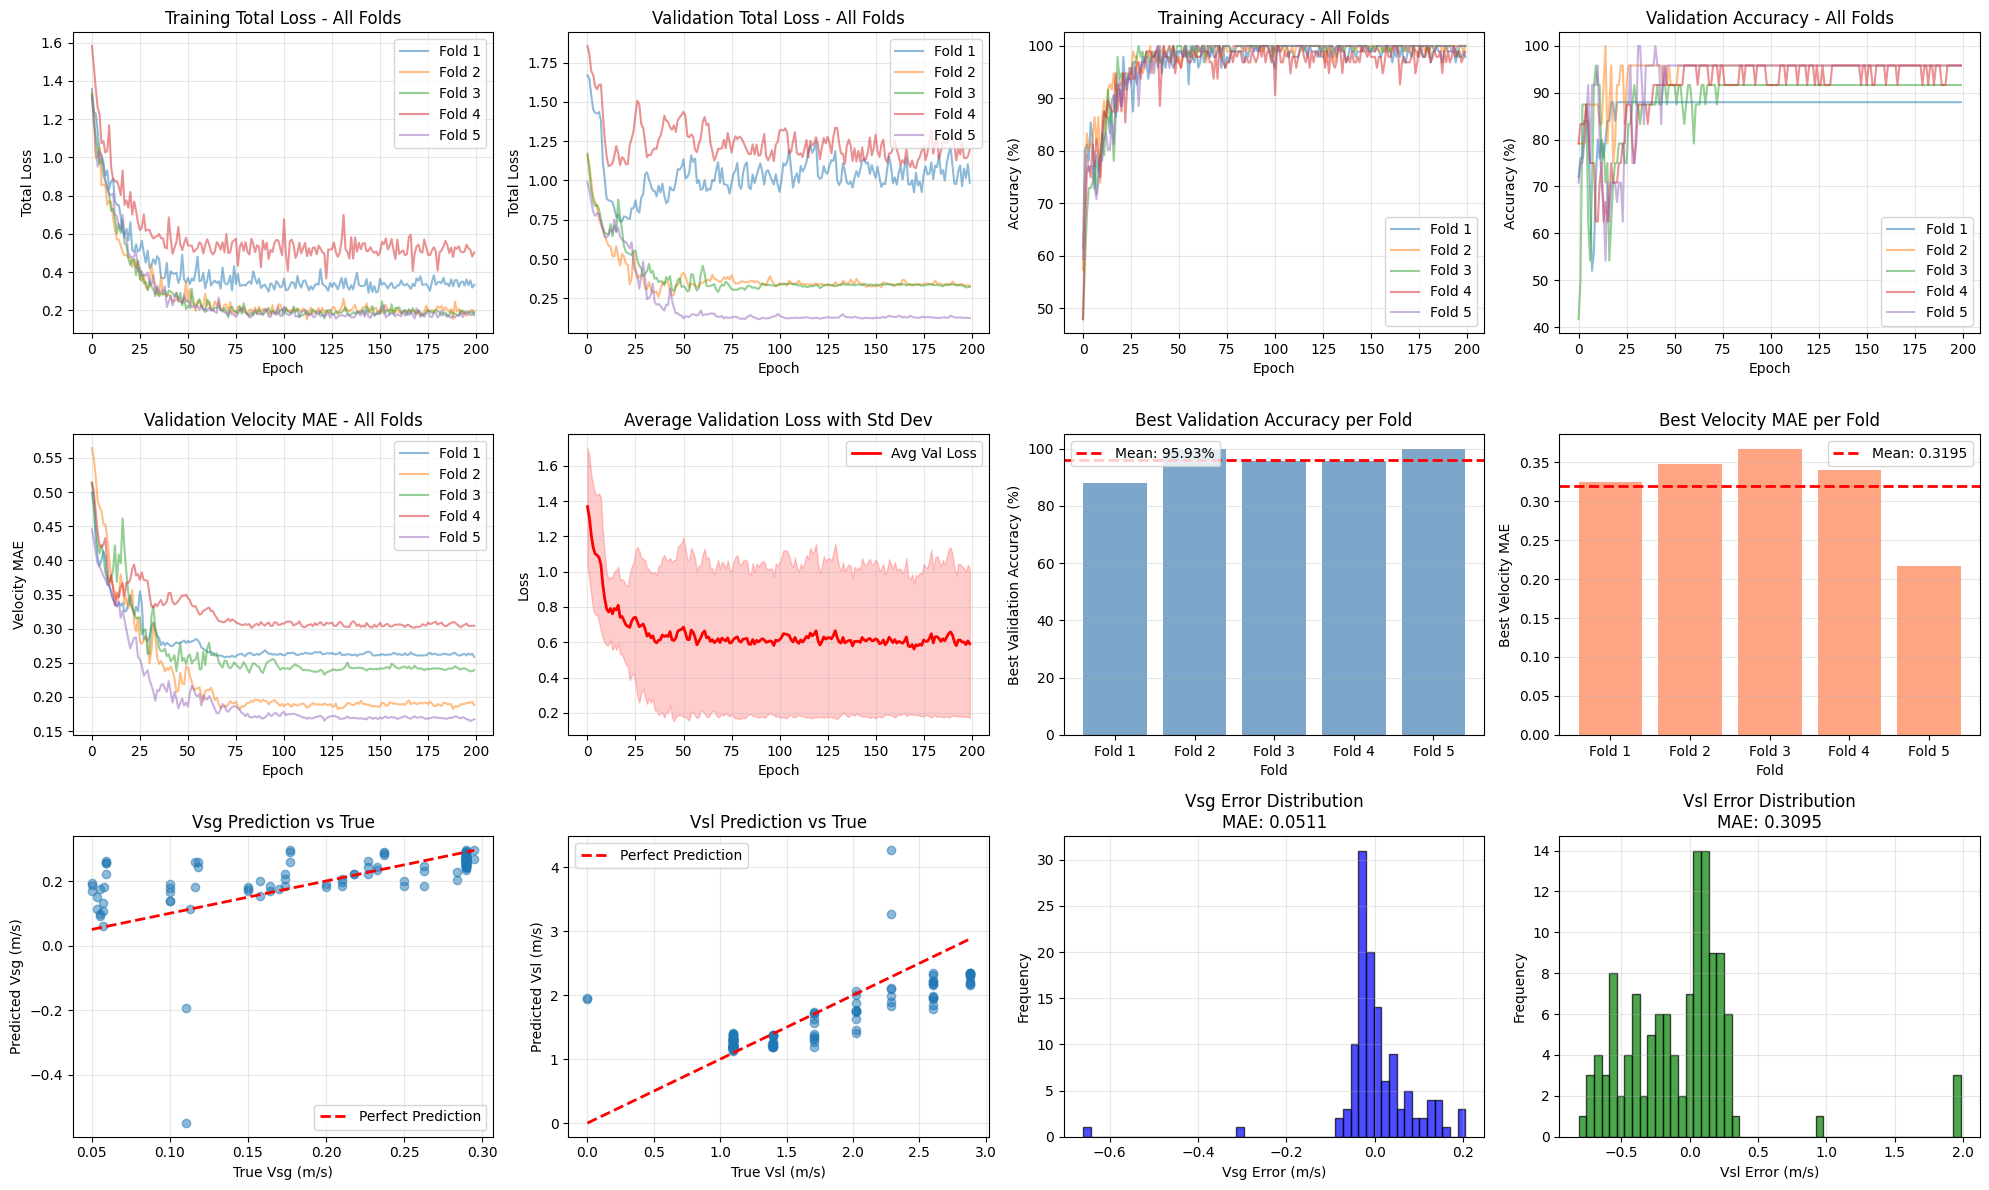

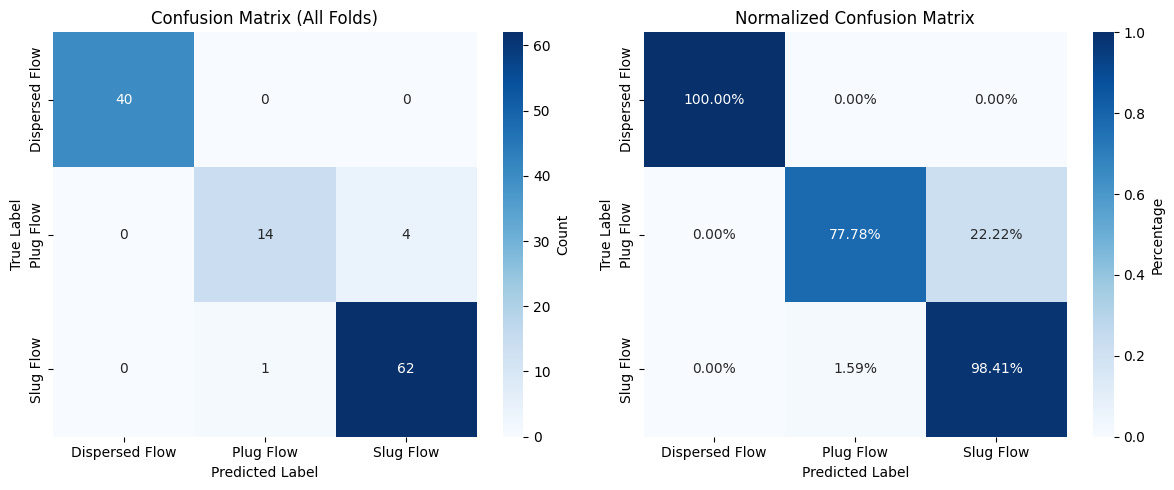


MULTI-TASK K-FOLD CROSS-VALIDATION RESULTS

Overall Classification Report:
                precision    recall  f1-score   support

Dispersed Flow     1.0000    1.0000    1.0000        40
     Plug Flow     0.9333    0.7778    0.8485        18
     Slug Flow     0.9394    0.9841    0.9612        63

      accuracy                         0.9587       121
     macro avg     0.9576    0.9206    0.9366       121
  weighted avg     0.9585    0.9587    0.9573       121


Fold-wise Results:
------------------------------------------------------------
Fold 1:
  Best Validation Accuracy: 88.00%
  Best Velocity MAE (scaled): 0.3248
Fold 2:
  Best Validation Accuracy: 100.00%
  Best Velocity MAE (scaled): 0.3478
Fold 3:
  Best Validation Accuracy: 95.83%
  Best Velocity MAE (scaled): 0.3677
Fold 4:
  Best Validation Accuracy: 95.83%
  Best Velocity MAE (scaled): 0.3406
Fold 5:
  Best Validation Accuracy: 100.00%
  Best Velocity MAE (scaled): 0.2166
----------------------------------------------

In [11]:
if __name__ == "__main__":
    print("Starting Multi-Task PINN Training with Reproducibility...")
    print(f"Random seed: 42")
    print(f"Device: {DEVICE}")
    best_model, fold_results, scalers = kfold_train_multitask()
    print("\nTraining completed successfully!")
    print("\nScalers saved for inference:")
    print(f"  Vsg scaler: {scalers['vsg']}")
    print(f"  Vsl scaler: {scalers['vsl']}")

# External Validation

VIDEO RETRIEVAL SYSTEM FOR FLOW REGIME CLASSIFICATION
Model loaded from best_multitask_pinn_fold_1.pth
Model validation accuracy: 88.0
Loaded video library with 20 videos
Flow regimes: {'Dispersed Flow': 12, 'Plug Flow': 4, 'Slug Flow': 4}

Computing video library embeddings...
  Processed 5/20 videos
  Processed 10/20 videos
  Processed 15/20 videos
  Processed 20/20 videos
Computed 20 video embeddings
Processing test file: SlugFlow-Vsl=1.1-Vsg=0.29.xlsx

Test data loaded:
  Number of windows: 133
  True Vsg: 0.290 m/s
  True Vsl: 1.100 m/s

Running inference...

Prediction Results:
  Predicted Flow Regime: Slug Flow
  Confidence: 0.607
  Predicted Vsg: 0.212 m/s
  Predicted Vsl: 1.057 m/s

Retrieving top-5 similar videos...

Top-4 Retrieved Videos:
----------------------------------------------------------------------
1. sf-Vsg=0.177-Vsl=1.4-vid2.mp4
   Vsg=0.177 m/s, Vsl=1.400 m/s
   Similarity Score: 0.5568

2. sf-Vsg=0.237-Vsl=1.4-vid3.mp4
   Vsg=0.237 m/s, Vsl=1.400 m/s
   Simila

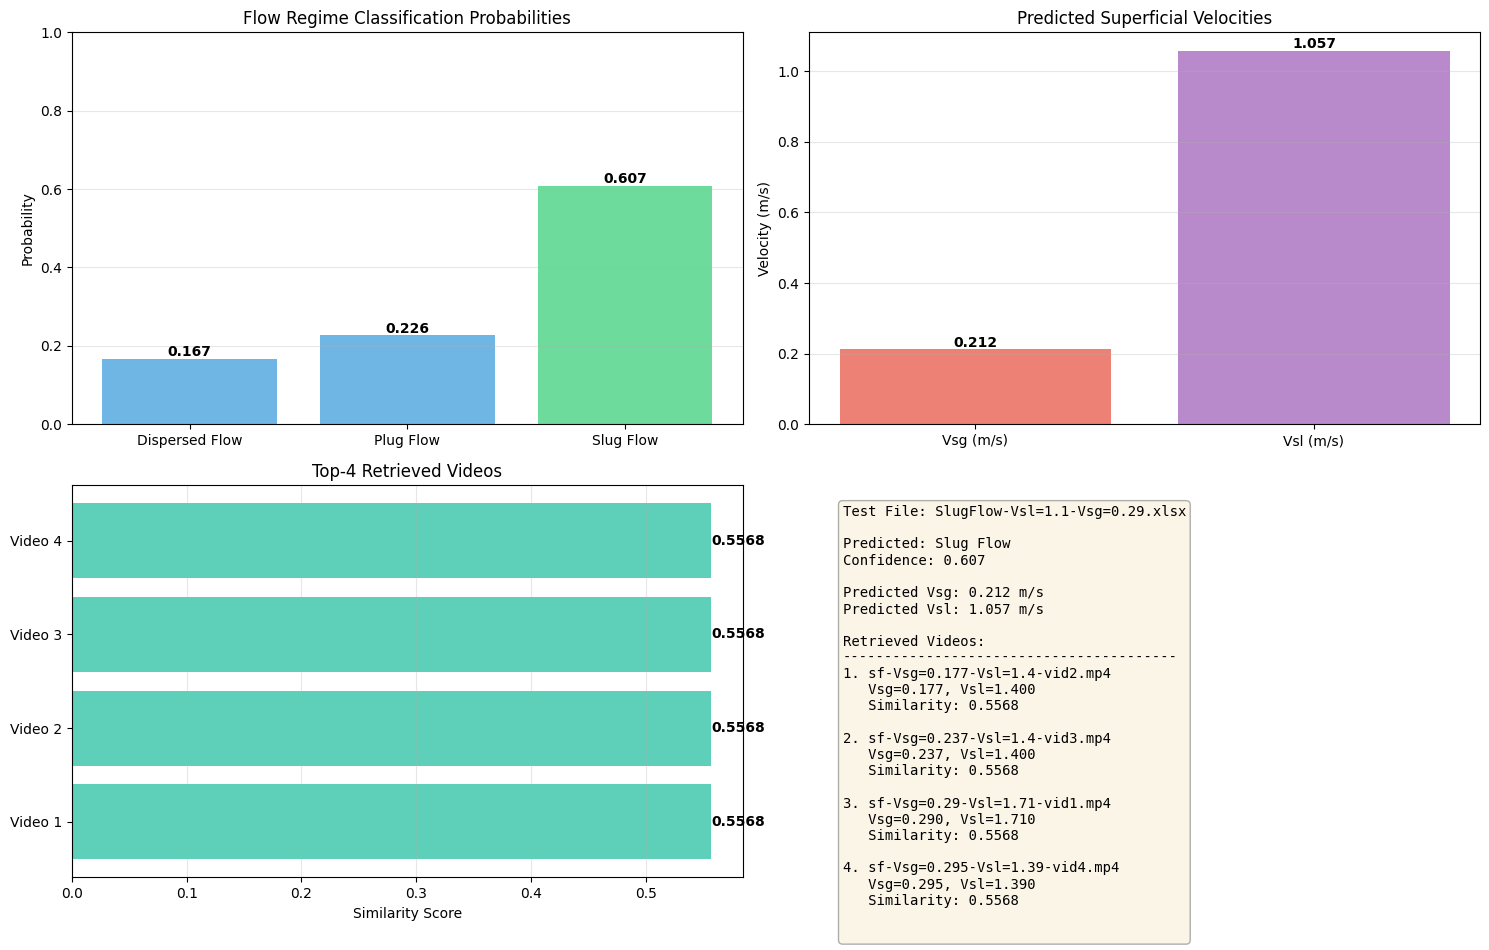


Playing top retrieved video...


Playing: sf-Vsg=0.177-Vsl=1.4-vid2.mp4


Processing test file: DispersedFlow-Vsl=2.88-Vsg=0.05.xlsx

Test data loaded:
  Number of windows: 129
  True Vsg: 0.050 m/s
  True Vsl: 2.880 m/s

Running inference...

Prediction Results:
  Predicted Flow Regime: Slug Flow
  Confidence: 0.890
  Predicted Vsg: 0.247 m/s
  Predicted Vsl: 2.491 m/s

Retrieving top-5 similar videos...

Top-4 Retrieved Videos:
----------------------------------------------------------------------
1. sf-Vsg=0.177-Vsl=1.4-vid2.mp4
   Vsg=0.177 m/s, Vsl=1.400 m/s
   Similarity Score: 0.4021

2. sf-Vsg=0.237-Vsl=1.4-vid3.mp4
   Vsg=0.237 m/s, Vsl=1.400 m/s
   Similarity Score: 0.4021

3. sf-Vsg=0.29-Vsl=1.71-vid1.mp4
   Vsg=0.290 m/s, Vsl=1.710 m/s
   Similarity Score: 0.4021

4. sf-Vsg=0.295-Vsl=1.39-vid4.mp4
   Vsg=0.295 m/s, Vsl=1.390 m/s
   Similarity Score: 0.4021


Visualization saved: retrieval_results_DispersedFlow-Vsl=2.88-Vsg=0.05.png


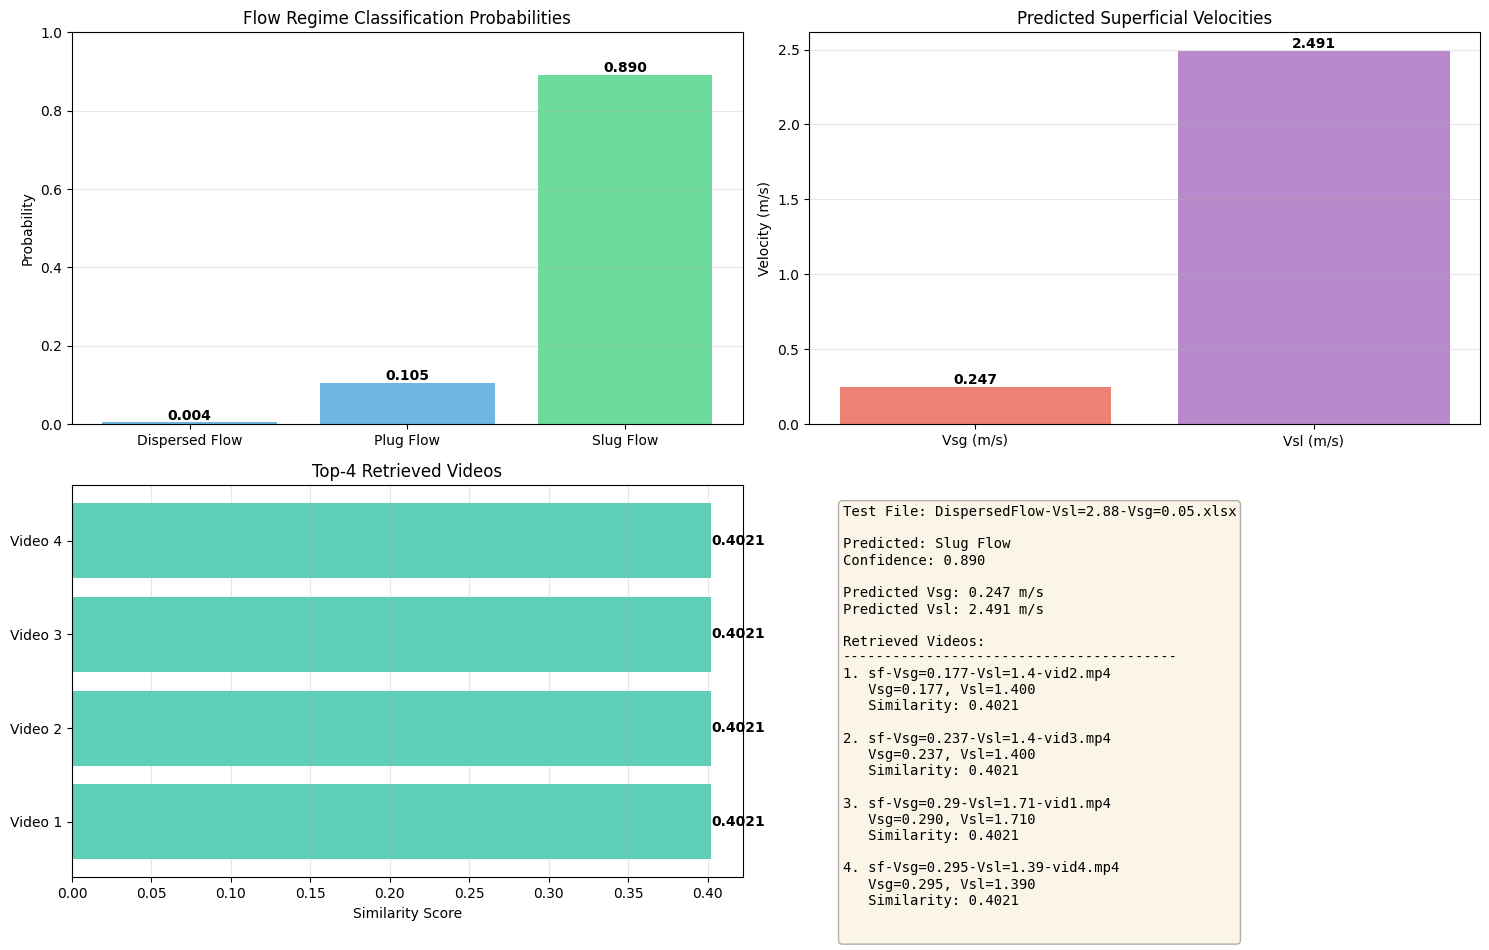


Playing top retrieved video...


Playing: sf-Vsg=0.177-Vsl=1.4-vid2.mp4


Video retrieval completed successfully!


In [35]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import re
import cv2
from scipy.fft import fft, fftfreq
from sklearn.preprocessing import StandardScaler, RobustScaler
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Video, display
import warnings
warnings.filterwarnings('ignore')

# ==================== CONFIGURATION ====================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Physics constants
PIPE_DIAMETER = 2 * 0.0254
PIPE_LENGTH = 7.25
GRAVITY = 9.81
RHO_WATER = 998
RHO_AIR_MEAN = 1.49

# Model hyperparameters (must match training)
WINDOW_SIZE = 40
STRIDE = 20
HIDDEN_SIZE = 128
NUM_CLASSES = 3

# Retrieval parameters
TOP_K = 5  # Number of similar videos to retrieve

# Paths
VIDEO_LIBRARY_CSV = r"D:\Research\Multiphase Visual Twin\Papers\Paper1\Project\20Hz-Training-Dataset\Code\video_library.csv"
MODEL_PATH = "best_multitask_pinn_fold_1.pth"  # Use best fold model
TEST_DATA_DIR = r"D:\Research\Multiphase Visual Twin\Papers\Paper1\Project\20Hz-Training-Dataset\Code\External-Validation\Good"

CLASS_NAMES = ["Dispersed Flow", "Plug Flow", "Slug Flow"]

# ==================== MODEL DEFINITION ====================
class MultiTaskPINN(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_classes=3):
        super(MultiTaskPINN, self).__init__()
        
        # Shared CNN backbone for pressure signal processing
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.4)
        
        # Feature processing
        self.fc_features = nn.Sequential(
            nn.Linear(8, 64),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        
        # Velocity processing
        self.fc_velocities = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        
        conv_output_size = 64 * (WINDOW_SIZE // 2)
        combined_size = conv_output_size + 64 + 32
        
        # Shared representation layer
        self.shared_layer = nn.Sequential(
            nn.Linear(combined_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        
        # Task 1: Flow Regime Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size // 2, num_classes)
        )
        
        # Task 2: Velocity Regression Head
        self.velocity_regressor = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size // 2, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
        
        # Task 3: Physics-based pressure prediction
        self.physics_net = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
    
    def forward(self, pressure_window, features, velocities):
        # Process pressure signal through CNN
        x = pressure_window.unsqueeze(1)
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        
        # Process features and velocities
        feat = self.fc_features(features)
        vel = self.fc_velocities(velocities)
        
        # Combine all features
        combined = torch.cat([x, feat, vel], dim=1)
        
        # Shared representation
        shared_repr = self.shared_layer(combined)
        
        # Multi-task outputs
        class_output = self.classifier(shared_repr)
        velocity_output = self.velocity_regressor(shared_repr)
        physics_output = self.physics_net(shared_repr)
        
        return class_output, velocity_output, physics_output, shared_repr

# ==================== UTILITY FUNCTIONS ====================
def extract_velocities_from_filename(filename):
    """Extract Vsg and Vsl from filename"""
    vsg_match = re.search(r'Vsg=([\d.]+)', filename)
    vsl_match = re.search(r'Vsl=([\d.]+)', filename)
    vsg = float(vsg_match.group(1).rstrip('.')) if vsg_match else 0.0
    vsl = float(vsl_match.group(1).rstrip('.')) if vsl_match else 0.0
    return vsg, vsl

def extract_features(pressure_window):
    """Extract features from pressure window"""
    features = []
    features.append(np.mean(pressure_window))
    features.append(np.std(pressure_window))
    features.append(np.max(pressure_window) - np.min(pressure_window))
    gradient = np.gradient(pressure_window)
    features.append(np.mean(gradient))
    features.append(np.std(gradient))
    features.append(np.max(np.abs(gradient)))
    if len(pressure_window) > 4:
        freqs = fftfreq(len(pressure_window), d=0.5)
        fft_vals = np.abs(fft(pressure_window))
        positive_freqs = freqs[:len(freqs)//2]
        positive_fft = fft_vals[:len(fft_vals)//2]
        if len(positive_fft) > 0:
            dominant_freq_idx = np.argmax(positive_fft)
            features.append(positive_freqs[dominant_freq_idx])
            features.append(positive_fft[dominant_freq_idx])
        else:
            features.append(0.0)
            features.append(0.0)
    else:
        features.append(0.0)
        features.append(0.0)
    return np.array(features)

def load_scalers_from_training():
    """
    Create scalers from training data to ensure consistency
    You should save these during training and load them here
    For now, we'll create dummy scalers - replace with actual saved scalers
    """
    # TODO: Load actual scalers saved during training
    scaler_features = StandardScaler()
    scaler_pressure = StandardScaler()
    scaler_vsg = RobustScaler()
    scaler_vsl = RobustScaler()
    
    print("WARNING: Using dummy scalers. Load actual scalers from training for accurate results!")
    
    return scaler_features, scaler_pressure, scaler_vsg, scaler_vsl

def load_video_library(csv_path):
    """Load video library from CSV"""
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Video library CSV not found: {csv_path}")
    
    df = pd.read_csv(csv_path)
    print(f"Loaded video library with {len(df)} videos")
    print(f"Flow regimes: {df['flow_regime'].value_counts().to_dict()}")
    return df

def cosine_similarity(vec1, vec2):
    """Calculate cosine similarity between two vectors"""
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    return dot_product / (norm1 * norm2 + 1e-8)

def euclidean_distance(vec1, vec2):
    """Calculate Euclidean distance between two vectors"""
    return np.linalg.norm(vec1 - vec2)

# ==================== INFERENCE CLASS ====================
class VideoRetrievalSystem:
    def __init__(self, model_path, video_library_csv, device=DEVICE):
        self.device = device
        self.model = MultiTaskPINN(input_size=WINDOW_SIZE, 
                                   hidden_size=HIDDEN_SIZE, 
                                   num_classes=NUM_CLASSES).to(device)
        
        # Load trained model
        checkpoint = torch.load(model_path, map_location=device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()
        print(f"Model loaded from {model_path}")
        print(f"Model validation accuracy: {checkpoint.get('val_acc', 'N/A')}")
        
        # Load scalers (in production, load saved scalers)
        self.scaler_features, self.scaler_pressure, self.scaler_vsg, self.scaler_vsl = load_scalers_from_training()
        
        # Load video library
        self.video_library = load_video_library(video_library_csv)
        
        # Precompute video embeddings
        self.video_embeddings = None
        
    def preprocess_test_data(self, file_path):
        """Load and preprocess test data"""
        df = pd.read_excel(file_path)
        
        if 'Pressure/bar' not in df.columns:
            raise ValueError(f"'Pressure/bar' column not found in {file_path}")
        
        pressure = df['Pressure/bar'].values
        filename = os.path.basename(file_path)
        vsg_true, vsl_true = extract_velocities_from_filename(filename)
        
        # Create windows
        windows = []
        for i in range(0, len(pressure) - WINDOW_SIZE + 1, STRIDE):
            window = pressure[i:i+WINDOW_SIZE]
            if len(window) == WINDOW_SIZE:
                windows.append(window)
        
        return np.array(windows), vsg_true, vsl_true, filename
    
    def predict_flow_regime(self, pressure_windows, vsg_input, vsl_input):
        """Predict flow regime and extract embeddings"""
        # Extract features for all windows
        features_list = [extract_features(window) for window in pressure_windows]
        features = np.array(features_list)
        
        # Scale inputs (using fit_transform for now - should use pre-fitted scalers)
        pressure_scaled = self.scaler_pressure.fit_transform(pressure_windows)
        features_scaled = self.scaler_features.fit_transform(features)
        
        # Prepare velocity input
        vsg_scaled = self.scaler_vsg.fit_transform([[vsg_input]])[0]
        vsl_scaled = self.scaler_vsl.fit_transform([[vsl_input]])[0]
        velocities_scaled = np.hstack([vsg_scaled, vsl_scaled])
        velocities_input = np.tile(velocities_scaled, (len(pressure_windows), 1))
        
        # Convert to tensors
        pressure_tensor = torch.FloatTensor(pressure_scaled).to(self.device)
        features_tensor = torch.FloatTensor(features_scaled).to(self.device)
        velocities_tensor = torch.FloatTensor(velocities_input).to(self.device)
        
        # Inference
        with torch.no_grad():
            class_output, velocity_output, physics_output, embeddings = self.model(
                pressure_tensor, features_tensor, velocities_tensor
            )
            
            # Get predictions
            class_probs = torch.softmax(class_output, dim=1)
            avg_class_probs = class_probs.mean(dim=0).cpu().numpy()
            predicted_class = torch.argmax(torch.tensor(avg_class_probs)).item()
            
            # Average velocity predictions
            avg_velocity = velocity_output.mean(dim=0).cpu().numpy()
            vsg_pred = self.scaler_vsg.inverse_transform(avg_velocity[0].reshape(-1, 1))[0, 0]
            vsl_pred = self.scaler_vsl.inverse_transform(avg_velocity[1].reshape(-1, 1))[0, 0]
            
            # Average embedding for similarity
            avg_embedding = embeddings.mean(dim=0).cpu().numpy()
        
        results = {
            'predicted_class': predicted_class,
            'predicted_class_name': CLASS_NAMES[predicted_class],
            'class_probabilities': avg_class_probs,
            'predicted_vsg': vsg_pred,
            'predicted_vsl': vsl_pred,
            'embedding': avg_embedding
        }
        
        return results
    
    def compute_video_library_embeddings(self):
        """Precompute embeddings for all videos in library"""
        print("\nComputing video library embeddings...")
        embeddings = []
        
        for idx, row in self.video_library.iterrows():
            # Use the true velocities from the video
            vsg = row['vsg']
            vsl = row['vsl']
            
            # Create a dummy pressure window (you might want to load actual pressure data)
            # For now, using a simple sine wave as placeholder
            dummy_pressure = np.sin(np.linspace(0, 4*np.pi, WINDOW_SIZE)) + np.random.normal(0, 0.1, WINDOW_SIZE)
            dummy_pressure = dummy_pressure.reshape(1, -1)
            
            # Get embedding
            result = self.predict_flow_regime(dummy_pressure, vsg, vsl)
            embeddings.append(result['embedding'])
            
            if (idx + 1) % 5 == 0:
                print(f"  Processed {idx + 1}/{len(self.video_library)} videos")
        
        self.video_embeddings = np.array(embeddings)
        print(f"Computed {len(embeddings)} video embeddings")
    
    def retrieve_similar_videos(self, query_embedding, query_class, top_k=TOP_K, 
                                similarity_metric='cosine'):
        """Retrieve top-k similar videos from the same flow regime"""
        # Filter videos by predicted flow regime
        same_regime_videos = self.video_library[
            self.video_library['flow_regime_idx'] == query_class
        ].copy()
        
        if len(same_regime_videos) == 0:
            print(f"No videos found for flow regime: {CLASS_NAMES[query_class]}")
            return pd.DataFrame()
        
        # Get embeddings for same regime videos
        same_regime_indices = same_regime_videos.index.tolist()
        same_regime_embeddings = self.video_embeddings[same_regime_indices]
        
        # Calculate similarities
        if similarity_metric == 'cosine':
            similarities = [
                cosine_similarity(query_embedding, video_emb) 
                for video_emb in same_regime_embeddings
            ]
        else:  # euclidean
            similarities = [
                -euclidean_distance(query_embedding, video_emb)  # Negative for sorting
                for video_emb in same_regime_embeddings
            ]
        
        same_regime_videos['similarity_score'] = similarities
        
        # Sort by similarity and get top-k
        top_videos = same_regime_videos.nlargest(top_k, 'similarity_score')
        
        return top_videos
    
    def visualize_results(self, test_file, results, retrieved_videos):
        """Visualize prediction results"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # 1. Classification probabilities
        ax1 = axes[0, 0]
        colors = ['#2ecc71' if i == results['predicted_class'] else '#3498db' 
                  for i in range(NUM_CLASSES)]
        bars = ax1.bar(CLASS_NAMES, results['class_probabilities'], color=colors, alpha=0.7)
        ax1.set_ylabel('Probability')
        ax1.set_title('Flow Regime Classification Probabilities')
        ax1.set_ylim([0, 1])
        for bar, prob in zip(bars, results['class_probabilities']):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{prob:.3f}', ha='center', va='bottom', fontweight='bold')
        ax1.grid(axis='y', alpha=0.3)
        
        # 2. Velocity predictions
        ax2 = axes[0, 1]
        velocities = ['Vsg (m/s)', 'Vsl (m/s)']
        predicted_vals = [results['predicted_vsg'], results['predicted_vsl']]
        bars = ax2.bar(velocities, predicted_vals, color=['#e74c3c', '#9b59b6'], alpha=0.7)
        ax2.set_ylabel('Velocity (m/s)')
        ax2.set_title('Predicted Superficial Velocities')
        for bar, val in zip(bars, predicted_vals):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
        ax2.grid(axis='y', alpha=0.3)
        
        # 3. Retrieved videos similarity scores
        ax3 = axes[1, 0]
        if len(retrieved_videos) > 0:
            video_labels = [f"Video {i+1}" for i in range(len(retrieved_videos))]
            similarity_scores = retrieved_videos['similarity_score'].values
            bars = ax3.barh(video_labels, similarity_scores, color='#1abc9c', alpha=0.7)
            ax3.set_xlabel('Similarity Score')
            ax3.set_title(f'Top-{len(retrieved_videos)} Retrieved Videos')
            for bar, score in zip(bars, similarity_scores):
                width = bar.get_width()
                ax3.text(width, bar.get_y() + bar.get_height()/2.,
                        f'{score:.4f}', ha='left', va='center', fontweight='bold')
            ax3.grid(axis='x', alpha=0.3)
        else:
            ax3.text(0.5, 0.5, 'No videos retrieved', ha='center', va='center')
            ax3.set_xlim([0, 1])
        
        # 4. Retrieved videos info
        ax4 = axes[1, 1]
        ax4.axis('off')
        if len(retrieved_videos) > 0:
            info_text = f"Test File: {os.path.basename(test_file)}\n\n"
            info_text += f"Predicted: {results['predicted_class_name']}\n"
            info_text += f"Confidence: {results['class_probabilities'][results['predicted_class']]:.3f}\n\n"
            info_text += f"Predicted Vsg: {results['predicted_vsg']:.3f} m/s\n"
            info_text += f"Predicted Vsl: {results['predicted_vsl']:.3f} m/s\n\n"
            info_text += "Retrieved Videos:\n"
            info_text += "-" * 40 + "\n"
            for idx, (_, row) in enumerate(retrieved_videos.iterrows(), 1):
                info_text += f"{idx}. {row['filename']}\n"
                info_text += f"   Vsg={row['vsg']:.3f}, Vsl={row['vsl']:.3f}\n"
                info_text += f"   Similarity: {row['similarity_score']:.4f}\n\n"
        else:
            info_text = "No videos retrieved"
        
        ax4.text(0.05, 0.95, info_text, transform=ax4.transAxes,
                fontsize=10, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
        
        plt.tight_layout()
        output_file = f"retrieval_results_{os.path.basename(test_file).replace('.xlsx', '.png')}"
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"\nVisualization saved: {output_file}")
        plt.show()
    
    def play_video(self, video_path):
        """Display video in Jupyter notebook"""
        if os.path.exists(video_path):
            try:
                display(Video(video_path, width=800))
                print(f"Playing: {os.path.basename(video_path)}")
            except Exception as e:
                print(f"Error playing video: {e}")
                print("Attempting alternative display method...")
                self.play_video_opencv(video_path)
        else:
            print(f"Video not found: {video_path}")
    
    def play_video_opencv(self, video_path, max_frames=300):
        """Play video using OpenCV (for non-Jupyter environments)"""
        cap = cv2.VideoCapture(video_path)
        
        if not cap.isOpened():
            print(f"Error opening video: {video_path}")
            return
        
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        delay = int(1000 / fps)
        frame_count = 0
        
        print(f"Playing: {os.path.basename(video_path)}")
        print(f"FPS: {fps}, Press 'q' to quit")
        
        while True:
            ret, frame = cap.read()
            if not ret or frame_count > max_frames:
                break
            
            # Resize for display
            height, width = frame.shape[:2]
            if width > 1280:
                scale = 1280 / width
                new_width = 1280
                new_height = int(height * scale)
                frame = cv2.resize(frame, (new_width, new_height))
            
            cv2.imshow('Video Retrieval', frame)
            frame_count += 1
            
            if cv2.waitKey(delay) & 0xFF == ord('q'):
                break
        
        cap.release()
        cv2.destroyAllWindows()
    
    def run_retrieval(self, test_file_path, top_k=TOP_K):
        """Main retrieval pipeline"""
        print("="*70)
        print(f"Processing test file: {os.path.basename(test_file_path)}")
        print("="*70)
        
        # Load and preprocess test data
        pressure_windows, vsg_true, vsl_true, filename = self.preprocess_test_data(test_file_path)
        print(f"\nTest data loaded:")
        print(f"  Number of windows: {len(pressure_windows)}")
        print(f"  True Vsg: {vsg_true:.3f} m/s")
        print(f"  True Vsl: {vsl_true:.3f} m/s")
        
        # Predict flow regime
        print("\nRunning inference...")
        results = self.predict_flow_regime(pressure_windows, vsg_true, vsl_true)
        
        print(f"\nPrediction Results:")
        print(f"  Predicted Flow Regime: {results['predicted_class_name']}")
        print(f"  Confidence: {results['class_probabilities'][results['predicted_class']]:.3f}")
        print(f"  Predicted Vsg: {results['predicted_vsg']:.3f} m/s")
        print(f"  Predicted Vsl: {results['predicted_vsl']:.3f} m/s")
        
        # Retrieve similar videos
        print(f"\nRetrieving top-{top_k} similar videos...")
        retrieved_videos = self.retrieve_similar_videos(
            results['embedding'], 
            results['predicted_class'], 
            top_k=top_k
        )
        
        if len(retrieved_videos) > 0:
            print(f"\nTop-{len(retrieved_videos)} Retrieved Videos:")
            print("-" * 70)
            for idx, (_, row) in enumerate(retrieved_videos.iterrows(), 1):
                print(f"{idx}. {row['filename']}")
                print(f"   Vsg={row['vsg']:.3f} m/s, Vsl={row['vsl']:.3f} m/s")
                print(f"   Similarity Score: {row['similarity_score']:.4f}")
                print()
        
        # Visualize results
        self.visualize_results(test_file_path, results, retrieved_videos)
        
        return results, retrieved_videos

# ==================== MAIN EXECUTION ====================
if __name__ == "__main__":
    print("="*70)
    print("VIDEO RETRIEVAL SYSTEM FOR FLOW REGIME CLASSIFICATION")
    print("="*70)
    
    # Initialize retrieval system
    retrieval_system = VideoRetrievalSystem(
        model_path=MODEL_PATH,
        video_library_csv=VIDEO_LIBRARY_CSV,
        device=DEVICE
    )
    
    # Precompute video embeddings (do this once)
    retrieval_system.compute_video_library_embeddings()
    
    # Test files
    test_files = [
        r"D:\Research\Multiphase Visual Twin\Papers\Paper1\Project\20Hz-Training-Dataset\Code\External-Validation\Good\SlugFlow-Vsl=1.1-Vsg=0.29.xlsx",
        r"D:\Research\Multiphase Visual Twin\Papers\Paper1\Project\20Hz-Training-Dataset\Code\External-Validation\Good\DispersedFlow-Vsl=2.88-Vsg=0.05.xlsx"
    ]
    
    # Process each test file
    all_results = []
    for test_file in test_files:
        if os.path.exists(test_file):
            results, retrieved_videos = retrieval_system.run_retrieval(test_file, top_k=TOP_K)
            all_results.append({
                'test_file': test_file,
                'results': results,
                'retrieved_videos': retrieved_videos
            })
            
            # Play top video
            if len(retrieved_videos) > 0:
                top_video_path = retrieved_videos.iloc[0]['video_path']
                print(f"\n{'='*70}")
                print("Playing top retrieved video...")
                print(f"{'='*70}")
                retrieval_system.play_video(top_video_path)
            
            print("\n" + "="*70 + "\n")
        else:
            print(f"Test file not found: {test_file}\n")
    
    print("Video retrieval completed successfully!")